In [ ]:
google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir("/content/drive/MyDrive/NLP/lab_4")

# Word Embeddings

În procesarea limbajului natural, **incorporarea cuvintelor** este un termen folosit pentru reprezentarea cuvintelor sub forma unui *vector care codifică și ***sensul*** cuvintelor*, astfel încât cuvintele care sunt mai apropiate ca sens să fie apropiate și în spațiul vectorial. 

Cu ajutorul embedding-urilor putem surprinde contextul unui cuvânt dintr-un document, asemănarea semantică și sintactică, relația cu alte cuvinte etc. 

Printre tehnicile de vectorizare cu reținere a sensului, amintim: word2vec, GloVe, fastText


<img src= "https://miro.medium.com/max/1356/1*5F4TXdFYwqi-BWTToQPIfg.jpeg">

## 1. Word2vec

Word2Vec este una dintre cele mai populare tehnici de încorporare a cuvintelor ce folosește o *rețea neuronală superficială*. A fost dezvoltat de Tomas Mikolov în 2013 la Google (articolul [aici](https://arxiv.org/pdf/1310.4546.pdf)).

Word2vec antrenează modele de cuvinte cu ajutorul cuvintelor învecinate din corpus, și face acest lucru în două moduri:

*   fie folosind context pentru a prezice un cuvânt țintă (o metodă cunoscută sub numele de **CBOW** - Continous Bag Of Words, sau "sac continuu de cuvinte")
*   fie folosind un cuvânt pentru a prezice un context țintă, care se numește **skip-gram**.

Noi vom folosi metoda din urmă, deoarece produce rezultate mai precise pe seturi mari de date. 

<img src= "https://wiki.pathmind.com/images/wiki/word2vec_diagrams.png" width="500" height="300">



### CBOW - Continous Bag of Words

Această arhitectură este foarte asemănătoare cu o rețea neuronală feed forward. 

Intuiția din spatele acestui model este destul de simplă. Să presupunem că avem expresia „Have a great day”, cuvântul țintă „a” și cuvintele de context să fie [„have”, „great”, „day”]. Acest model va lua reprezentările distribuite ale cuvintelor de context pentru a încerca să prezică cuvântul țintă. 



### Modelul Skip-Gram 

Modelul skip-gram este o rețea neuronală simplă cu un strat ascuns antrenat pentru a prezice probabilitatea ca un anumit cuvânt să fie prezent atunci când este prezent un cuvânt de intrare. În mod intuitiv, vă puteți imagina că modelul skip-gram este opusul modelului CBOW. În această arhitectură, modelul ia cuvântul curent ca intrare și încearcă să prezică cu precizie cuvintele dinainte și după acest cuvânt curent. Acest model încearcă în esență să învețe și să prezică cuvintele de context în jurul cuvântului de intrare specificat. Procesul poate fi descris vizual, așa cum se vede mai jos. 

Totul începe cu o fereastră glisantă de o anumită dimensiune: centrul ei este ținta, iar restul este contextul. Următorul exemplu este din [acest tutorial](https://lilianweng.github.io/posts/2017-10-15-word-embedding/).

“The man who passes the sentence should swing the sword.” – Ned Stark

| Sliding window (size = 5)  |   Target word  |   Context  |
|:--------------------------:|:--------------:|:----------:|
| [The man who]  | the |  man, who  |
| [The man who passes]  | man  | the, who, passes  |
| [The man who passes the] |  who  | the, man, passes, the |
| [man who passes the sentence] | passes | man, who, the, sentence |
| … | … | … |
|[sentence should swing the sword] |	swing |	sentence, should, the, sword |
|[should swing the sword] |	the |	should, swing, sword |
|[swing the sword] |	sword	| swing, the |

Fiecare pereche context-țintă este tratată ca o nouă observație în date. De exemplu, cuvântul țintă „swing” în cazul de mai sus produce patru exemple de antrenament: (“swing”, “sentence”), (“swing”, “should”), (“swing”, “the”), and (“swing”, “sword”).




![img](https://lilianweng.github.io/posts/2017-10-15-word-embedding/word2vec-skip-gram.png)

Având în vedere dimensiunea vocabularului $V$, suntem pe cale să învățăm vectori de încorporare a cuvintelor de dimensiunea $N$. Modelul învață să prezică un cuvânt de context (ieșire) folosind un cuvânt țintă (intrare) la un moment dat.

Conform figurii de mai sus:

* Atât cuvântul de intrare $w_i$ cât și cuvântul de ieșire $w_j$ sunt codificați one-hot în vectori binari $x$ și $y$ de dimensiunea $V$.
* În primul rând, înmulțirea vectorului binar $x$ și a matricei de încorporare a cuvântului $W$ de dimensiunea $V × N$ ne oferă vectorul de încorporare al cuvântului de intrare $w_i$: rândul i al matricei $W $.
* Acest vector de dimensiune nou descoperit formează stratul ascuns.
* Înmulțirea stratului ascuns și a matricei contextului cuvânt $W'$ de dimensiunea $N \times V$ produce vectorul codificat one-hot de ieșire $y$.
* Matricea contextului de ieșire $W'$ codifică semnificațiile cuvintelor ca context, diferit de matricea de încorporare.

NOTĂ: În ciuda numelui, $W'$ este independent de $W$, nu o transpunere sau inversă sau orice altceva.

### Modelul Continuous Bag-of-Words

Continuous Bag-of-Words (CBOW) este un alt model similar pentru învățarea vectorilor de cuvinte. Acesta prezice cuvântul țintă (adică „swing”) din cuvintele contextului sursă (adică „sentence should the sword”).

![img](https://lilianweng.github.io/posts/2017-10-15-word-embedding/word2vec-cbow.png)

Deoarece există mai multe cuvinte contextuale, facem media vectorilor de cuvinte corespunzători acestora, construiți prin înmulțirea vectorului de intrare și a matricei $W$. Deoarece etapa de mediere netezește o mulțime de informații de distribuție, unii oameni cred că modelul CBOW este mai bun pentru un set de date mic.

În ambele cazuri, cea mai comună metodă de învățare a rețelei neuronale este reducerea la minimum a funcției de pierdere, care este [entropia încrucișată  categorică](https://lilianweng.github.io/posts/2017-10-15-word-embedding/#cross-entropy). Măsoară între probabilitățile prezise $p$, rezultate de model și etichetele binare adevărate $y$.

Mai multe explicații despre această măsurătoare sunt [aici](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

### Implementare

Ne vom ajuta de librăria Gensim pentru a implementa vectorizarea word2vec, și de nltk pentru tokenizare.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
! pip install gensim==4.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-4.0.1-cp39-cp39-linux_x86_64.whl size=26057779 sha256=3240cd7895e829faf60798bfe2b4636994913fca0c3953ad957fce74dd26ec99
  Stored in directory: /root/.cache/pip/wheels/20/74/75/72ec1172891bdecb4ee73fbc2c71d5a150f165b1d0c2ea04e1
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import word_tokenize
from gensim.models import Word2Vec as w2v

/usr/local/lib/python3.9/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Mai întâi ne vom downloada textul pentru lucru:

In [ ]:
from urllib.request import urlretrieve
urlretrieve('https://raw.githubusercontent.com/vatsal220/medium_articles/main/w2v/data/shakespeare.txt', 'shakespeare.txt')

('shakespeare.txt', <http.client.HTTPMessage at 0x7f60b6afa4c0>)

In [ ]:
# constants
PATH = './shakespeare.txt'
sw = stopwords.words('english')
plt.style.use('ggplot')

# import data
lines = []
with open(PATH, 'r') as f:
    for l in f:
        lines.append(l)

print(lines[:10])

['"ACT I"\n', '"SCENE I. London. The palace."\n', '"Enter KING HENRY, LORD JOHN OF LANCASTER, the EARL of WESTMORELAND, SIR WALTER BLUNT, and others"\n', '"So shaken as we are, so wan with care,"\n', '"Find we a time for frighted peace to pant,"\n', '"And breathe short-winded accents of new broils"\n', '"To be commenced in strands afar remote."\n', '"No more the thirsty entrance of this soil"\n', '"Shall daub her lips with her own children\'s blood,"\n', '"Nor more shall trenching war channel her fields,"\n']


### Preprocesarea datelor

*   Cuvintele-stop eliminate din aceste rânduri aparțin unui vocabular modern. Aplicația și datele au o importanță ridicată pentru tipul de tactici de preprocesare necesare pentru curățarea cuvintelor.
*   În scenariul nostru, cuvinte precum „you” sau „yourself” ar fi prezente în cuvintele oprite și eliminate din rânduri, cu toate acestea, deoarece acestea sunt date de text Shakespeare, aceste tipuri de cuvinte nu ar fi folosite. În schimb, „thou” sau „thyself” ar putea fi util de eliminat. 
*   Aici nu vom intra în detalii extreme în identificarea cuvintelor stop dintr-un secol diferit, dar să fiți conștienți că ar trebui. 





In [ ]:
# remove new lines
lines = [line.rstrip('\n') for line in lines]

# make all characters lower
lines = [line.lower() for line in lines]

# remove punctuations from each line
lines = [line.translate(str.maketrans('', '', string.punctuation)) for line in lines]

# tokenize
lines = [word_tokenize(line) for line in lines]

def remove_stopwords(lines, sw = sw):
    '''
    The purpose of this function is to remove stopwords from a given array of 
    lines.
    
    params:
        lines (Array / List) : The list of lines you want to remove the stopwords from
        sw (Set) : The set of stopwords you want to remove
        
    example:
        lines = remove_stopwords(lines = lines, sw = sw)
    '''
    
    res = []
    for line in lines:
        original = line
        line = [w for w in line if w not in sw]
        if len(line) < 1:
            line = original
        res.append(line)
    return res
    
filtered_lines = remove_stopwords(lines = lines, sw = sw)

print(filtered_lines[:10])

[['act'], ['scene', 'london', 'palace'], ['enter', 'king', 'henry', 'lord', 'john', 'lancaster', 'earl', 'westmoreland', 'sir', 'walter', 'blunt', 'others'], ['shaken', 'wan', 'care'], ['find', 'time', 'frighted', 'peace', 'pant'], ['breathe', 'shortwinded', 'accents', 'new', 'broils'], ['commenced', 'strands', 'afar', 'remote'], ['thirsty', 'entrance', 'soil'], ['shall', 'daub', 'lips', 'childrens', 'blood'], ['shall', 'trenching', 'war', 'channel', 'fields']]


Încorporarea (crearea embeddings-urilor) 

In [ ]:
w = w2v(
    filtered_lines,
    min_count=3,  
    sg = 1,     # sg=1 inseamna ca se foloseste skip-gram, sg=0 inseamna ca se foloseste CBOW  
    window=7      
)       


Vectorii creați vor fi stocați într-o structură de tip KeyedVectors, ce reprezintă în esență o mapare între chei și vectori. Fiecare vector este identificat prin cheia sa de căutare, cuvântul, deci această mapare este de obicei de tipul {str => matrice numpy 1D}.

Pentru unele modele cheia poate fi un documet, un nod în graph, etc.

In [ ]:
print(type(w.wv))
print(type(w.wv.key_to_index))

<class 'gensim.models.keyedvectors.KeyedVectors'>
<class 'dict'>


In [ ]:
print(w.wv.key_to_index)

{'thou': 0, 'thy': 1, 'shall': 2, 'thee': 3, 'good': 4, 'lord': 5, 'come': 6, 'sir': 7, 'well': 8, 'would': 9, 'enter': 10, 'let': 11, 'ill': 12, 'love': 13, 'hath': 14, 'man': 15, 'one': 16, 'go': 17, 'upon': 18, 'like': 19, 'know': 20, 'us': 21, 'say': 22, 'may': 23, 'make': 24, 'yet': 25, 'king': 26, 'must': 27, 'see': 28, 'tis': 29, 'give': 30, 'take': 31, 'speak': 32, 'mine': 33, 'tell': 34, 'exeunt': 35, 'much': 36, 'think': 37, 'never': 38, 'time': 39, 'exit': 40, 'heart': 41, 'great': 42, 'hear': 43, 'art': 44, 'death': 45, 'men': 46, 'away': 47, 'doth': 48, 'life': 49, 'father': 50, 'hand': 51, 'made': 52, 'look': 53, 'scene': 54, 'ay': 55, 'thus': 56, 'true': 57, 'pray': 58, 'sweet': 59, 'god': 60, 'fair': 61, 'master': 62, 'lady': 63, 'day': 64, 'two': 65, 'done': 66, 'leave': 67, 'eyes': 68, 'name': 69, 'heaven': 70, 'fear': 71, 'blood': 72, 'could': 73, 'honour': 74, 'night': 75, 'therefore': 76, 'nothing': 77, 'till': 78, 'noble': 79, 'poor': 80, 'ever': 81, 'world': 82, 

Să punem acești vectori într-un dataframe:

In [ ]:
emb_df = (
    pd.DataFrame(
        [w.wv.get_vector(str(n)) for n in w.wv.key_to_index],
        index = w.wv.key_to_index
    )
)
print(emb_df.shape)
emb_df.head()

(11628, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
thou,0.015067,-0.068904,0.512482,0.950478,-0.466606,-0.457195,0.150126,0.421440,-0.291496,-0.157824,...,0.284735,0.156325,0.403094,0.278580,0.987932,0.563756,-0.536918,-0.388121,0.055886,0.290478
thy,-0.036832,0.293842,0.413813,0.373977,-0.034181,-0.189935,0.186049,0.694179,-0.191500,-0.417664,...,0.129123,-0.223915,0.449838,-0.231611,0.416575,0.222958,-0.311459,-0.487058,-0.002302,0.115538
shall,0.216160,0.189668,0.089954,0.186163,0.418498,-0.090004,-0.075814,0.393807,-0.145393,0.129447,...,0.577316,0.057272,0.121164,-0.114215,0.598797,0.232372,0.253459,0.051547,0.389549,0.099247
thee,-0.259563,0.296639,0.544357,0.502805,-0.041791,-0.049878,0.096191,0.552323,0.096011,-0.231670,...,0.284011,-0.104739,0.115588,-0.068827,0.577411,0.344605,-0.063983,0.201708,0.169283,-0.022762
good,0.224583,0.033895,0.140090,-0.149930,0.018134,0.180904,0.370020,0.642300,-0.340602,0.004157,...,0.423963,-0.194273,0.233005,-0.051958,0.578275,-0.086964,0.327944,-0.179126,0.410417,-0.168606


Dacă spre exemplu vrem să vedem cuvintele cele mai similare ale cuvântului 'thou':

In [ ]:
print(w.wv.most_similar('thou'))

[('art', 0.8276862502098083), ('thyself', 0.8174947500228882), ('villain', 0.7778539657592773), ('dost', 0.7735433578491211), ('hast', 0.7504250407218933), ('wherefore', 0.7175040245056152), ('kill', 0.713331937789917), ('wilt', 0.6931731700897217), ('didst', 0.686363935470581), ('slave', 0.6838467717170715)]


### Incarcărea modelelor Word2Vec + Vizualizări

Folosind biblioteca `gensim` putem descărca și modele Word2Vec deja antrenate pe corpusuri mari. Un astfel de model este modelul celor de la Google.

In [ ]:
import gensim.downloader as api
google_model = api.load("word2vec-google-news-300")

[=================================================-] 99.9% 1661.7/1662.8MB downloaded


In [ ]:
google_model.most_similar("cat")

[('cats', 0.8099379539489746),
 ('dog', 0.760945737361908),
 ('kitten', 0.7464985251426697),
 ('feline', 0.7326234579086304),
 ('beagle', 0.7150582671165466),
 ('puppy', 0.7075453400611877),
 ('pup', 0.6934291124343872),
 ('pet', 0.6891531348228455),
 ('felines', 0.6755931973457336),
 ('chihuahua', 0.6709762215614319)]

In [ ]:
google_model.similarity("cat", "feline")

0.73262334

Folosind proprietatea de mai jos putem accesa vocabularul modelului Word2Vec

In [ ]:
vocab = google_model.index_to_key
print(len(vocab))
print(vocab[:20])

3000000
['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are']


Putem acum incerca sa generam vectori dupa formule de tipul: `king - man + woman`

In [ ]:
google_model.most_similar(positive=["king", "woman"], negative=["man"], topn=5)

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581)]

In [ ]:
google_model.most_similar(positive=["doctor", "she"], negative=["he"], topn=5)

[('nurse', 0.6588720679283142),
 ('gynecologist', 0.647172212600708),
 ('nurse_practitioner', 0.6255376935005188),
 ('midwife', 0.6002784371376038),
 ('pediatrician', 0.5921324491500854)]

In [ ]:
google_model.most_similar(positive=["computer_programmer", "woman"], negative=["man"], topn=5)

[('homemaker', 0.5627118945121765),
 ('housewife', 0.5105047225952148),
 ('graphic_designer', 0.505180299282074),
 ('schoolteacher', 0.497949481010437),
 ('businesswoman', 0.493489146232605)]

Puteți observa cum în ultimele două exemple este ilustrată una dintre cele mai mari probleme ale embeddings-urilor: gender bias.

Problema provine de la faptul ca gender bias-ul din textele cu care a fost antrenat modelul este încorporat și în vectorii calculați pentru cuvinte. În ultimii ani s-a lucrat la proiectarea unor metode pentru a inlătura acest efect (de-biasing), însă acestea depășesc scopul acestui laborator.

Pentru a vizualiza embeddings-urile pentru o mulțime de cuvinte trebuie să ținem cont că nu putem afișa grafice în mai mult de 3 dimensiuni.

Pentru a realiza un plot cu word embeddings, trebuie mai intâi să aplicam o reducere a dimensionalitații asupra vectorilor, pentru a-i aduce in 2D. O astfel de metodă este [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) (Principal Component Analysis). Această metodă reduce numărul de dimensiuni și păstreaza pe cât mai mult posibil varianta mulțimii de vectori.

In [ ]:
# vom plota embedding-urile pentru următoarele cuvinte
words = ["king", "cat", "table"]

# aceștia sunt vectorii lor
vectors = [google_model[word] for word in words]

print(vectors[0])

[ 1.25976562e-01  2.97851562e-02  8.60595703e-03  1.39648438e-01
 -2.56347656e-02 -3.61328125e-02  1.11816406e-01 -1.98242188e-01
  5.12695312e-02  3.63281250e-01 -2.42187500e-01 -3.02734375e-01
 -1.77734375e-01 -2.49023438e-02 -1.67968750e-01 -1.69921875e-01
  3.46679688e-02  5.21850586e-03  4.63867188e-02  1.28906250e-01
  1.36718750e-01  1.12792969e-01  5.95703125e-02  1.36718750e-01
  1.01074219e-01 -1.76757812e-01 -2.51953125e-01  5.98144531e-02
  3.41796875e-01 -3.11279297e-02  1.04492188e-01  6.17675781e-02
  1.24511719e-01  4.00390625e-01 -3.22265625e-01  8.39843750e-02
  3.90625000e-02  5.85937500e-03  7.03125000e-02  1.72851562e-01
  1.38671875e-01 -2.31445312e-01  2.83203125e-01  1.42578125e-01
  3.41796875e-01 -2.39257812e-02 -1.09863281e-01  3.32031250e-02
 -5.46875000e-02  1.53198242e-02 -1.62109375e-01  1.58203125e-01
 -2.59765625e-01  2.01416016e-02 -1.63085938e-01  1.35803223e-03
 -1.44531250e-01 -5.68847656e-02  4.29687500e-02 -2.46582031e-02
  1.85546875e-01  4.47265

In [ ]:
from sklearn.decomposition import PCA

# folosim PCA pentru a reduce vectorii la 2D
pca = PCA(n_components=2)
pca.fit(vectors)
vectors_2d = pca.transform(vectors)

print(vectors_2d[0])

[-1.9506067  -1.13054296]


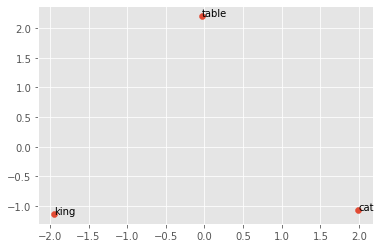

In [ ]:
import matplotlib.pyplot as plt

x = [v[0] for v in vectors_2d]
y = [v[1] for v in vectors_2d]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(words):
    ax.annotate(txt, (x[i], y[i]))

plt.show()

Biblioteca `gensim` vine si cu un corpus destul de variat de texte (`text8`), deja preprocesat pe care il puteti folosi pentru a antrena un model Word2Vec de la zero.

In [ ]:
text8 = api.load("text8")  # descarcam corpusul
text8_model = w2v(text8).wv

[==================================================] 100.0% 31.6/31.6MB downloaded


In [ ]:
print(text8_model.most_similar('shall'))

[('will', 0.7988917827606201), ('should', 0.7740709185600281), ('must', 0.7586725354194641), ('would', 0.7183447480201721), ('let', 0.7036172151565552), ('might', 0.7003437876701355), ('could', 0.6984180808067322), ('cannot', 0.6953948140144348), ('ought', 0.6942723989486694), ('lest', 0.6894617676734924)]


## 2. GloVe 

GloVe este altă metodă de determinare a embedding-urilor ce folosește concepte elementare din statistică. În timp ce Word2vec, se bazează doar pe "local statistics" (apariția cuvintelor la nivelul unei singure propoziții), GloVe încorporează "global statistics" (word co-occurrence matrix).

Să considerăm, spre exemplu, două cuvinte care apar în contexte/ferestre/windows comune în textele din corpus. Dacă acestea apar de $100$ de ori sau de $1000$ de ori impreună, modelul Word2Vec nu va fi afectat foarte mult (perechea va apărea mai des în datele de antrenare, dar nu va influența direct predicția modelului). GloVe rezolvă acest neajuns prin calculul matricei de co-occurrence în care pentru fiecare pereche de cuvinte numără de câte ori au aparut aceste cuvinte în același context.

De exemplu, pentru un corpus format doar din propoziția "the cat sat on the mat", folosind o fereastra de dimensiune 2, avem urmatoarea matrice de co-ocurence:

![co-ocurence matrix](https://miro.medium.com/max/434/1*QWcK8CIDs8kMkOwsOxvywA.png)

Unde M[i][j] = numarul de aparitii ale secventei $w_i w_j$ la nivelul intregului corpus. 

Plecând de la această matrice se ajunge la o ecuație, cu o funcție de cost (optimizare). Mai multe detalii explicate [aici](https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010).

## 3. FastText

fastText este o altă metodă de încorporare a cuvintelor - o extensie a modelului word2vec. În loc să învețe vectori pentru cuvinte direct, fastText reprezintă fiecare cuvânt ca un n-gram de caractere. 

De exemplu, dacă avem cuvântul „artificial” cu n=3, reprezentarea fastText a acestui cuvânt va fi <ar, art, rti, tif, ifi, fic, ici, ial, al>, unde parantezele unghiulare indică începutul și sfârșitul cuvântului. Acest lucru ajută la captarea sensului cuvintelor mai scurte și permite înglobărilor să "înțeleagă" sufixele și prefixele. Odată ce cuvântul a fost reprezentat folosind n-grame la nivel de caracter, se folosește un model skip-gram pentru a le învăța. Metoda folosită la antrenarea unui model fastText este [*train_supervised*](https://fasttext.cc/docs/en/supervised-tutorial.html).

Avantaj - fastText funcționează bine în vectorizarea cuvintelor rare - chiar dacă un cuvânt nu a fost văzut în timpul antrenării, acesta poate fi împărțit în n-grame pentru a obține înglobarea acestuia. 

Pentru fastText există o librărie Python dedicată. Următoarele 4 celule de cod necesită multă memorie pentru execuție, așa că nu le vom executa acum, sunt cu titlu informativ.

In [ ]:
! pip install fastText

Cei de la fastText au realizat o serie de vectori preantrenați pe corpusurile Common Crawl și Wikipedia, pentru 157 de limbi! Ei se găsesc [aici](https://fasttext.cc/docs/en/crawl-vectors.html). Aceste modele au fost antrenate folosind CBOW iar dimensiunea vectorilor este de 300. Ei pot fi folosiți la vectorizarea textelor pe care dorim să le folosim la clasificare, sau la orice alt task ce necesită texte vectorizate.

In [ ]:
import fasttext.util
fasttext.util.download_model('ro', if_exists='ignore')  # Română
ft = fasttext.load_model('cc.ro.300.bin')

Putem reduce dimensiunea vectorilor, pentru simplitate:

In [ ]:
import fasttext
ft.get_dimension()
fasttext.util.reduce_model(ft, 100)
ft.get_dimension()

100

Și acum putem utiliza acești vectori pentru a calcula, de exemplu, cele mai apropiate cuvinte din spațiu ale unui alt cuvânt:

In [ ]:
print(ft.get_nearest_neighbors('bună'))

[(0.8661828637123108, 'excelentă'), (0.8131385445594788, 'serioasă'), (0.8016242384910583, 'sigură'), (0.8003990650177002, 'proastă'), (0.7888690829277039, 'perfectă'), (0.787638247013092, 'suficientă'), (0.7846453189849854, 'simplă'), (0.7834456562995911, 'potrivită'), (0.7786563038825989, 'eficientă'), (0.7781667113304138, 'optimă')]


# TASK
## Deadline: 2 aprilie ora 23:59.

Formular pentru trimiterea temei: https://forms.gle/HA2Sy5cHvntSe1Pk7

1. Descarcăti un text mai mare in engleză (ex. un articol de pe wikipedia, vedeți cum mai jos).
2. Încărcați modelul Word2Vec de la Google, la fel ca în laborator.
3. (bonus) Afișați câte cuvinte (tokens) distincte din text sunt acoperite de model (modelul contine vectori pentru acele cuvinte), și câte cuvinte distincte din text nu sunt acoperite de model.
4. Determinați pentru toate perechile de cuvinte distincte din text care este similaritatea lor. Afișați top 3 cele mai similare perechi, și top 3 cele mai nesimilare.
5. În următoarele cerințe vom compara modelul Google cu cel antrenat în cadrul laboratorului pe corpusul `text8`. Pentru fiecare cuvânt din lista următoare determinați lista celor mai similare cuvinte conform modelului Google și lista celor mai similare cuvinte conform modelului text8: `smart, king, big`. Observați diferențe?
6. Plotați într-un grafic embeddings-urile reduse la 2 dimensiuni (folosind PCA) din modelul Google pentru cuvintele `car, motorcycle, bike, man, person, woman, child, king, queen, prince, plant, tree, flower`; separat construiți același grafic și pentru modelul antrenat folosind text8. Ce asemănări/diferențe observați? 

In [ ]:
! pip install wikipedia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11695 sha256=d423f5cf2067c808d955bf601fd10ba7ff3fb673038232d1b0ba318e858faf55
  Stored in directory: /root/.cache/pip/wheels/c2/46/f4/caa1bee71096d7b0cdca2f2a2af45cacf35c5760bee8f00948
Successfully built wikipedia


In [ ]:
# cum putem descarca continutul unui articol de pe wikipedia
import wikipedia
page_title = "Jazz"
wikipedia.set_lang("en")  # vrem articole in Engleza
page = wikipedia.page(page_title, auto_suggest=False)

print(page.content[:200])

Jazz is a music genre that originated in the African-American communities of New Orleans, Louisiana, United States, in the late 19th and early 20th centuries, with its roots in blues and ragtime. Sinc


Sources: 


*  https://towardsdatascience.com/word2vec-explained-49c52b4ccb71
*   https://wiki.pathmind.com/word2vec
*   https://blogs.sap.com/2019/07/03/glove-and-fasttext-two-popular-word-vector-models-in-nlp/
*   https://analyticsindiamag.com/guide-to-facebooks-fasttext-for-text-representations-and-classifiers/
